# Introduction to Python  

### Topic Modelling and Clustering documents  

This notebook is based on [this](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/), [this](http://www.brandonrose.org) and [this](http://www.brandonrose.org/top100) posts. [This](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730) one added later.

In [1]:
!pip install -U -q gensim mpld3 python-Levenshtein pyldavis
#!conda install -c conda-forge pyldavis
#!conda update -n base -c defaults conda

In [2]:
import re
import os
import codecs
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

#import matplotlib as mpl
from sklearn import feature_extraction
import mpld3

import pyLDAvis
import pyLDAvis.gensim_models

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
#%matplotlib notebook

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Specifying the path to the files  

In [4]:
datapath = "../Data/Texts/doccluster/"
outputs = "../Data/Texts/outputs/"

## 1 - [Documents Similarity](https://www.geeksforgeeks.org/measuring-the-document-similarity-in-python/)

Let's create some documents.  

In [5]:
raw_documents = ["I'm taking the show on the road.",
                 "My socks are a force multiplier.",
                 "I am the barber who cuts everyone's hair who doesn't cut their own.",
                 "Legend has it that the mind is a mad monkey.",
                 "I make my own fun."]

print("Number of documents:",len(raw_documents))

Number of documents: 5


We will use NLTK to tokenize.  
A document will now be a list of tokens.  

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rsouza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
gen_docs = [[w.lower() for w in word_tokenize(text)] for text in raw_documents]

print(gen_docs)

[['i', "'m", 'taking', 'the', 'show', 'on', 'the', 'road', '.'], ['my', 'socks', 'are', 'a', 'force', 'multiplier', '.'], ['i', 'am', 'the', 'barber', 'who', 'cuts', 'everyone', "'s", 'hair', 'who', 'does', "n't", 'cut', 'their', 'own', '.'], ['legend', 'has', 'it', 'that', 'the', 'mind', 'is', 'a', 'mad', 'monkey', '.'], ['i', 'make', 'my', 'own', 'fun', '.']]


We will create a dictionary from a list of documents.  
A dictionary maps every word to a number.  

In [8]:
dictionary = gensim.corpora.Dictionary(gen_docs)
print(dictionary[5])
print(dictionary.token2id['road'])
print("Number of words in dictionary:",len(dictionary))
for i in range(len(dictionary)):
    print(i, dictionary[i])

show
4
Number of words in dictionary: 36
0 'm
1 .
2 i
3 on
4 road
5 show
6 taking
7 the
8 a
9 are
10 force
11 multiplier
12 my
13 socks
14 's
15 am
16 barber
17 cut
18 cuts
19 does
20 everyone
21 hair
22 n't
23 own
24 their
25 who
26 has
27 is
28 it
29 legend
30 mad
31 mind
32 monkey
33 that
34 fun
35 make


Now we will create a corpus. A corpus is a list of bags of words.  
A bag-of-words representation for a document just lists the number of times each word occurs in the document.  

In [9]:
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
for d in corpus:
    print(d)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]
[(1, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
[(1, 1), (2, 1), (7, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2)]
[(1, 1), (7, 1), (8, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]
[(1, 1), (2, 1), (12, 1), (23, 1), (34, 1), (35, 1)]


Now we create a tf-idf model from the corpus.

In [10]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    s += len(i)
print(s)

TfidfModel(num_docs=5, num_nnz=47)
47


In [11]:
for d in tf_idf[corpus]:
    print(d)

[(0, 0.4262583060688039), (2, 0.13529174589513532), (3, 0.4262583060688039), (4, 0.4262583060688039), (5, 0.4262583060688039), (6, 0.4262583060688039), (7, 0.27058349179027064)]
[(8, 0.2640668814624488), (9, 0.46382576584030827), (10, 0.46382576584030827), (11, 0.46382576584030827), (12, 0.2640668814624488), (13, 0.46382576584030827)]
[(2, 0.08327819508571149), (7, 0.08327819508571149), (14, 0.2623812867136573), (15, 0.2623812867136573), (16, 0.2623812867136573), (17, 0.2623812867136573), (18, 0.2623812867136573), (19, 0.2623812867136573), (20, 0.2623812867136573), (21, 0.2623812867136573), (22, 0.2623812867136573), (23, 0.1493798172489513), (24, 0.2623812867136573), (25, 0.5247625734273146)]
[(7, 0.10934952319763026), (8, 0.19614512267839235), (26, 0.3445231800303735), (27, 0.3445231800303735), (28, 0.3445231800303735), (29, 0.3445231800303735), (30, 0.3445231800303735), (31, 0.3445231800303735), (32, 0.3445231800303735), (33, 0.3445231800303735)]
[(2, 0.19143057263818053), (12, 0.343

In [12]:
index_tmpfile = get_tmpfile("index")
sims = gensim.similarities.Similarity(index_tmpfile,tf_idf[corpus],num_features=len(dictionary))
print(sims)
print(type(sims))

Similarity index with 5 documents in 0 shards (stored under /tmp/tmpygbblrkb/index)
<class 'gensim.similarities.docsim.Similarity'>


Now create a query document and convert it to tf-idf.  

In [13]:
query_doc = [w.lower() for w in word_tokenize("Socks are a force for good.")]
print(query_doc)
query_doc_bow = dictionary.doc2bow(query_doc)
print(query_doc_bow)

query_doc_tf_idf = tf_idf[query_doc_bow]
print(query_doc_tf_idf)

['socks', 'are', 'a', 'force', 'for', 'good', '.']
[(1, 1), (8, 1), (9, 1), (10, 1), (13, 1)]
[(8, 0.31226270667960454), (9, 0.5484803253891997), (10, 0.5484803253891997), (13, 0.5484803253891997)]


We show an array of document similarities to query.  
We see that the second document is the most similar with the overlapping of socks and force.

In [14]:
sims[query_doc_tf_idf]

array([0.        , 0.84565616, 0.        , 0.06124881, 0.        ],
      dtype=float32)

## 2 - [Topic Modeling Example](http://www.cs.columbia.edu/~blei/topicmodeling.html)  

Analytics Industry is all about obtaining the “Information” from the data. With the growing amount of data in recent years, that too mostly unstructured, it’s difficult to obtain the relevant and desired information. But, technology has developed some powerful methods which can be used to mine through the data and fetch the information that we are looking for.  

One such technique in the field of text mining is Topic Modelling. As the name suggests, it is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Thus, assisting better decision making.  

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.



Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.  

Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. For Example – New York Times are using topic models to boost their user – article recommendation engines. Various professionals are using topic models for recruitment industries where they aim to extract latent features of job descriptions and map them to right candidates. They are being used to organize large datasets of emails, customer reviews, and user social media profiles.  

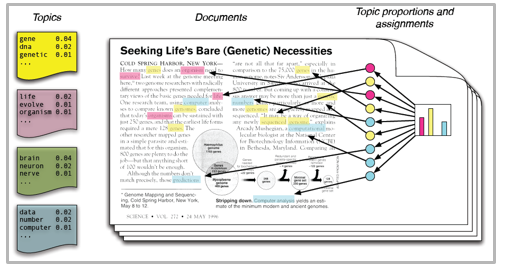

In [15]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling1.png')
Image(filename='../Data/Figs/Modeling1.png')

#### 2.1 - Latent Dirichlet Allocation for Topic Modeling  

There are many approaches for obtaining topics from a text such as – Term Frequency and Inverse Document Frequency. NonNegative Matrix Factorization techniques. Latent Dirichlet Allocation is the most popular topic modeling technique and in this article, we will discuss the same.  

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.  

LDA is a matrix factorization technique. In vector space, any corpus (collection of documents) can be represented as a document-term matrix. The following matrix shows a corpus of N documents D1, D2, D3 … Dn and vocabulary size of M words W1,W2 .. Wn. The value of i,j cell gives the frequency count of word Wj in Document Di.  

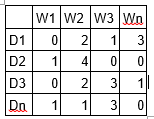

In [16]:
#Image(url='https://www.analyticsvidhya.com/wp-content/uploads/2016/08/Modeling2.png')
Image(filename='../Data/Figs/Modeling2.png')

LDA converts this Document-Term Matrix into two lower dimensional matrices – M1 and M2.
M1 is a document-topics matrix and M2 is a topic – terms matrix with dimensions (N,  K) and (K, M) respectively, where N is the number of documents, K is the number of topics and M is the vocabulary size.  

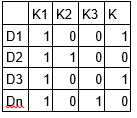

In [17]:
Image(filename='../Data/Figs/modeling3.png')

Notice that these two matrices already provides topic word and document topic distributions, However, these distribution needs to be improved, which is the main aim of LDA. LDA makes use of sampling techniques in order to improve these matrices.  

It Iterates through each word “w” for each document “d” and tries to adjust the current topic – word assignment with a new assignment. A new topic “k” is assigned to word “w” with a probability P which is a product of two probabilities p1 and p2.  

For every topic, two probabilities p1 and p2 are calculated. P1 – p(topic t / document d) = the proportion of words in document d that are currently assigned to topic t. P2 – p(word w / topic t) = the proportion of assignments to topic t over all documents that come from this word w.  

The current topic – word assignment is updated with a new topic with the probability, product of p1 and p2 . In this step, the model assumes that all the existing word – topic assignments except the current word are correct. This is essentially the probability that topic t generated word w, so it makes sense to adjust the current word’s topic with new probability.  

After a number of iterations, a steady state is achieved where the document topic and topic term distributions are fairly good. This is the convergence point of LDA.  

 
Parameters of LDA  

Alpha and Beta Hyperparameters – alpha represents document-topic density and Beta represents topic-word density. Higher the value of alpha, documents are composed of more topics and lower the value of alpha, documents contain fewer topics. On the other hand, higher the beta, topics are composed of a large number of words in the corpus, and with the lower value of beta, they are composed of few words.  

Number of Topics – Number of topics to be extracted from the corpus. Researchers have developed approaches to obtain an optimal number of topics by using Kullback Leibler Divergence Score. I will not discuss this in detail, as it is too mathematical. For understanding, one can refer to this[1] original paper on the use of KL divergence.  

Number of Topic Terms – Number of terms composed in a single topic. It is generally decided according to the requirement. If the problem statement talks about extracting themes or concepts, it is recommended to choose a higher number, if problem statement talks about extracting features or terms, a low number is recommended.  

Number of Iterations / passes – Maximum number of iterations allowed to LDA algorithm for convergence.  

#### 2.2 - Topic Modeling Example 1 - Gensim

In [18]:
# Here are the sample documents combining together to form a corpus.

doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
doc2 = "My father spends a lot of time driving my sister around to dance practice."
doc3 = "Doctors suggest that sugar may cause increased stress and blood pressure."
doc4 = "My father never seems to drive my sister to do better, but i think he should."
doc5 = "Health experts, as Doctors, say that Sugar is not good for your lifestyle."

# compile documents
doc_complete = [doc1, doc2, doc3, doc4, doc5]

Cleaning and Preprocessing

Cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the corpus.  

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/rsouza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rsouza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   

In [21]:
doc_clean

[['sugar', 'bad', 'consume', 'sister', 'like', 'sugar', 'father'],
 ['father',
  'spends',
  'lot',
  'time',
  'driving',
  'sister',
  'around',
  'dance',
  'practice'],
 ['doctor',
  'suggest',
  'sugar',
  'may',
  'cause',
  'increased',
  'stress',
  'blood',
  'pressure'],
 ['father', 'never', 'seems', 'drive', 'sister', 'better', 'think', 'should'],
 ['health', 'expert', 'doctor', 'say', 'sugar', 'good', 'lifestyle']]

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.  

In [22]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [23]:
doc_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2)],
 [(2, 1), (4, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(5, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)],
 [(2, 1), (4, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)],
 [(5, 1), (15, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]]

Running LDA Model  

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [24]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=50)

In [25]:
print(ldamodel.print_topics(num_topics=2, num_words=5))

[(0, '0.116*"sugar" + 0.064*"doctor" + 0.039*"pressure" + 0.039*"stress" + 0.039*"increased"'), (1, '0.079*"sister" + 0.079*"father" + 0.045*"driving" + 0.045*"dance" + 0.045*"time"')]


#### 2.3 - Topic Modeling using Scikit Learn

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

Gensim is an awesome library and scales really well to large text corpuses. Gensim, however does not include Non-negative Matrix Factorization (NMF), which can also be used to find topics in text. The mathematical basis underpinning NMF is quite different from LDA. NMF sometimes produces more meaningful topics for smaller datasets. NMF has been included in Scikit Learn for quite a while but LDA has only recently (late 2015) been included. The great thing about using Scikit Learn is that it brings API consistency which makes it almost trivial to perform Topic Modeling using both LDA and NMF. Scikit Learn also includes seeding options for NMF which greatly helps with algorithm convergence and offers both online and batch variants of LDA.

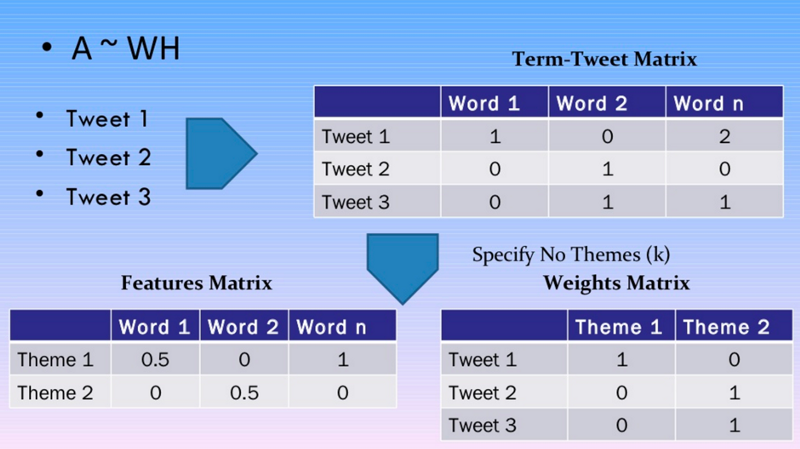

In [27]:
display(Image(os.path.join('../Data/','Figs', 'nmf.png'), width=700))

In [28]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [29]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

no_features = 1000

The creation of the bag of words matrix is very easy in Scikit Learn — all the heavy lifting is done by the feature extraction functionality provided for text datasets. A tf-idf transformer is applied to the bag of words matrix that NMF must process with the TfidfVectorizer. LDA on the other hand, being a probabilistic graphical model (i.e. dealing with probabilities) only requires raw counts, so a CountVectorizer is used. Stop words are removed and the number of terms included in the bag of words matrix is restricted to the top 1000.

In [30]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [31]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

As mentioned previously the algorithms are not able to automatically determine the number of topics and this value must be set when running the algorithm. Comprehensive documentation on available parameters is available for both NMF and LDA. Initialising the W and H matrices in NMF with ‘nndsvd’ rather than random initialisation improves the time it takes for NMF to converge. LDA can also be set to run in either batch or online mode.

In [32]:
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

Displaying and Evaluating Topics

The structure of the resulting matrices returned by both NMF and LDA is the same and the Scikit Learn interface to access the returned matrices is also the same. This is great and allows for a common Python method that is able to display the top words in a topic. Topics are not labeled by the algorithm — a numeric index is assigned.

The derived topics from NMF and LDA are displayed below. From the NMF derived topics, Topic 0 and 8 don’t seem to be about anything in particular but the other topics can be interpreted based upon there top words. LDA for the 20 Newsgroups dataset produces 2 topics with noisy data (i.e., Topic 4 and 7) and also some topics that are hard to interpret (i.e., Topic 3 and Topic 9). I’d say the NMF was able to find more meaningful topics in the 20 Newsgroups dataset.

In [33]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
people time right did good said say make way government
Topic 1:
window problem using server application screen display motif manager running
Topic 2:
god jesus bible christ faith believe christian christians sin church
Topic 3:
game team year games season players play hockey win league
Topic 4:
new 00 sale 10 price offer shipping condition 20 15
Topic 5:
thanks mail advance hi looking info help information address appreciated
Topic 6:
windows file files dos program version ftp ms directory running
Topic 7:
edu soon cs university ftp internet article email pub david
Topic 8:
key chip clipper encryption keys escrow government public algorithm nsa
Topic 9:
drive scsi drives hard disk ide floppy controller cd mac
Topic 10:
just ll thought tell oh little fine work wanted mean
Topic 11:
does know anybody mean work say doesn help exist program
Topic 12:
card video monitor cards drivers bus vga driver color memory
Topic 13:
like sounds looks look bike sound lot things really thing
To

In [34]:
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
people gun state control right guns crime states law police
Topic 1:
time question book years did like don space answer just
Topic 2:
mr line rules science stephanopoulos title current define int yes
Topic 3:
key chip keys clipper encryption number des algorithm use bit
Topic 4:
edu com cs vs w7 cx mail uk 17 send
Topic 5:
use does window problem way used point different case value
Topic 6:
windows thanks know help db does dos problem like using
Topic 7:
bike water effect road design media dod paper like turn
Topic 8:
don just like think know people good ve going say
Topic 9:
car new price good power used air sale offer ground
Topic 10:
file available program edu ftp information files use image version
Topic 11:
ax max b8f g9v a86 145 pl 1d9 0t 34u
Topic 12:
government law privacy security legal encryption court fbi technology information
Topic 13:
card bit memory output video color data mode monitor 16
Topic 14:
drive scsi disk mac hard apple drives controller software port
T

#### 2.4 - Tips to improve results of topic modeling

The results of topic models are completely dependent on the features (terms) present in the corpus. The corpus is represented as document term matrix, which in general is very sparse in nature. Reducing the dimensionality of the matrix can improve the results of topic modelling. Based on my practical experience, there are few approaches which do the trick.  

1. Frequency Filter – Arrange every term according to its frequency. Terms with higher frequencies are more likely to appear in the results as compared ones with low frequency. The low frequency terms are essentially weak features of the corpus, hence it is a good practice to get rid of all those weak features. An exploratory analysis of terms and their frequency can help to decide what frequency value should be considered as the threshold.  

2. Part of Speech Tag Filter – POS tag filter is more about the context of the features than frequencies of features. Topic Modelling tries to map out the recurring patterns of terms into topics. However, every term might not be equally important contextually. For example, POS tag IN contain terms such as – “within”, “upon”, “except”. “CD” contains – “one”,”two”, “hundred” etc. “MD” contains “may”, “must” etc. These terms are the supporting words of a language and can be removed by studying their post tags.  

3. Batch Wise LDA –In order to retrieve most important topic terms, a corpus can be divided into batches of fixed sizes. Running LDA multiple times on these batches will provide different results, however, the best topic terms will be the intersection of all batches.  

#### 2.5 - Topic Modelling for Feature Selection

Sometimes LDA can also be used as feature selection technique. Take an example of text classification problem where the training data contain category wise documents. If LDA is running on sets of category wise documents. Followed by removing common topic terms across the results of different categories will give the best features for a category.  

## 3 - Example: Clustering and Topic Modeling applied to film synopses

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

It will cover:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

#### 3.1 - Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

#### 3.1.1 - import three lists: titles, links and wikipedia synopses  

In [35]:
titles = open(os.path.join(datapath, 'title_list.txt')).read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]
print(str(len(titles)) + ' titles')

print(titles[0:5])

100 titles
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [36]:
links = open(os.path.join(datapath, 'link_list_imdb.txt')).read().split('\n')
links = links[:100]
print(str(len(links)) + ' links')

print(links[0:5])

100 links
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [37]:
synopses_wiki = open(os.path.join(datapath, 'synopses_list_wiki.txt'), encoding="utf8").read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

print(str(len(synopses_wiki)) + ' synopses')

print(synopses_wiki[0][0:627])

100 synopses
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedd


In [38]:
synopses_imdb = open(os.path.join(datapath,'synopses_list_imdb.txt'), encoding="utf8").read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

print(str(len(synopses_imdb)) + ' synopses')

print(synopses_imdb[0][0:627])

100 synopses


In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two y


In [39]:
#Joining the two synopses sources

synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
synopses[0]

'  On the day of his only daughter\'s wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito\'s youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito\'s godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter\'s wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito\'s youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito\'s godson   Johnny Fontane  Johnny Fontane  , a pop

#### 3.1.2 - Importing the genres

In [40]:
genres = open(os.path.join(datapath,'genres_list.txt')).read().split('\n')
genres = genres[:100]
print(str(len(genres)) + ' genres')

print(genres[0:5])

100 genres
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [41]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

#### 3.1.3 - Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [42]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [43]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [44]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [45]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [46]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#### 3.1.4 - Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

/home/rsouza/environments/default_env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 4.71 s, sys: 14.3 ms, total: 4.72 s
Wall time: 4.78 s
(100, 564)


In [48]:
terms = tfidf_vectorizer.get_feature_names()

In [49]:
terms[0:50]

["'d",
 "'s death",
 "'s father",
 "'s friend",
 "'s hous",
 "'s mother",
 'abandon',
 'abl',
 'accept',
 'accid',
 'accompani',
 'accus',
 'act',
 'action',
 'actual',
 'admit',
 'afterward',
 'ago',
 'agre',
 'air',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'american',
 'angri',
 'angrili',
 'ani',
 'announc',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'ask',
 'assign',
 'assist',
 'assum',
 'attack']

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [51]:
dist

array([[ 0.00000000e+00,  8.00612667e-01,  7.62919309e-01, ...,
         6.40317667e-01,  6.70731044e-01,  8.24020109e-01],
       [ 8.00612667e-01,  1.11022302e-16,  7.33522706e-01, ...,
         7.33496310e-01,  7.71593583e-01,  8.93000317e-01],
       [ 7.62919309e-01,  7.33522706e-01, -2.22044605e-16, ...,
         7.24210289e-01,  7.49546661e-01,  8.58322258e-01],
       ...,
       [ 6.40317667e-01,  7.33496310e-01,  7.24210289e-01, ...,
         2.22044605e-16,  4.51669244e-01,  9.17444019e-01],
       [ 6.70731044e-01,  7.71593583e-01,  7.49546661e-01, ...,
         4.51669244e-01,  0.00000000e+00,  8.68338789e-01],
       [ 8.24020109e-01,  8.93000317e-01,  8.58322258e-01, ...,
         9.17444019e-01,  8.68338789e-01, -2.22044605e-16]])

#### 3.1.5 - K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [52]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 72.1 ms, sys: 0 ns, total: 72.1 ms
Wall time: 111 ms


In [53]:
#from sklearn.externals import joblib
import joblib

joblib.dump(km, os.path.join(outputs, 'doc_cluster.pkl'))
km = joblib.load(os.path.join(outputs, 'doc_cluster.pkl'))
clusters = km.labels_.tolist()

In [54]:
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [55]:
frame.head(10)

,rank,title,cluster,genre
0,0,The Godfather,0,"[u' Crime', u' Drama']"
4,1,The Shawshank Redemption,4,"[u' Crime', u' Drama']"
0,2,Schindler's List,0,"[u' Biography', u' Drama', u' History']"
4,3,Raging Bull,4,"[u' Biography', u' Drama', u' Sport']"
4,4,Casablanca,4,"[u' Drama', u' Romance', u' War']"
4,5,One Flew Over the Cuckoo's Nest,4,[u' Drama']
0,6,Gone with the Wind,0,"[u' Drama', u' Romance', u' War']"
2,7,Citizen Kane,2,"[u' Drama', u' Mystery']"
4,8,The Wizard of Oz,4,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
3,9,Titanic,3,"[u' Drama', u' Romance']"


In [56]:
frame['cluster'].value_counts()

4    48
0    29
3     9
2     8
1     6
Name: cluster, dtype: int64

In [57]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    44.344828
1    52.833333
2    59.125000
3    51.666667
4    50.187500
Name: rank, dtype: float64

In [58]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print(f"Cluster {i} words:", end='')
    for ind in order_centroids[i, :6]:
        print(f" {vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')}", end=',')
    print()
    print()
    print(f"Cluster {i} titles:", end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(f' {title},', end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'killed', b'army', b'soldiers', b'war', b'family', b'men',

Cluster 0 titles: The Godfather, Schindler's List, Gone with the Wind, Lawrence of Arabia, The Sound of Music, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders of the Lost Ark, Doctor Zhivago, Patton, Braveheart, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Front, Giant, The Grapes of Wrath, Shane, Stagecoach, Mutiny on the Bounty,

Cluster 1 words: b'george', b'marries', b'family', b'woman', b'friends', b'john',

Cluster 1 titles: It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Tootsie,

Cluster 2 words: b'mr.', b'singing', b'music',

In [59]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [60]:
#export tables to HTML
html_output = frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False)

from IPython.core.display import display, HTML
display(HTML(html_output))

Rank,Title
27,It's a Wonderful Life
42,The Philadelphia Story
44,An American in Paris
66,The King's Speech
68,A Place in the Sun
76,Tootsie


#### 3.1.6 - Multidimensional scaling

In [61]:
from sklearn.manifold import MDS

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [62]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

#### 3.1.7 - Visualizing document clusters

In [63]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

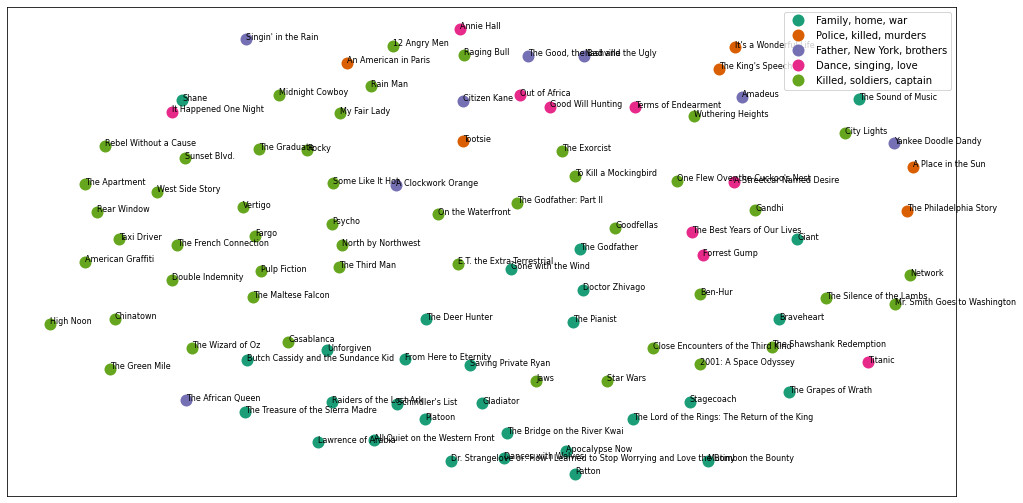

<Figure size 432x288 with 0 Axes>

In [64]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show()

#Saving the Fig
plt.savefig(os.path.join(outputs,'clusters_small_noaxes.png'), dpi=200)

The clustering plot looks great, but it would be better without overlapping labels. We are going to use D3.js (http://d3js.org/), a browser based/javascript interactive. We will use a matplotlib D3 wrapper called mpld3 (https://mpld3.github.io/). Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [65]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [66]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

In [67]:
#uncomment the below to export to html
#os.chdir(outputs)
#html = mpld3.fig_to_html(fig)
#print(html)

#### 3.1.8 - Hierarchical document clustering

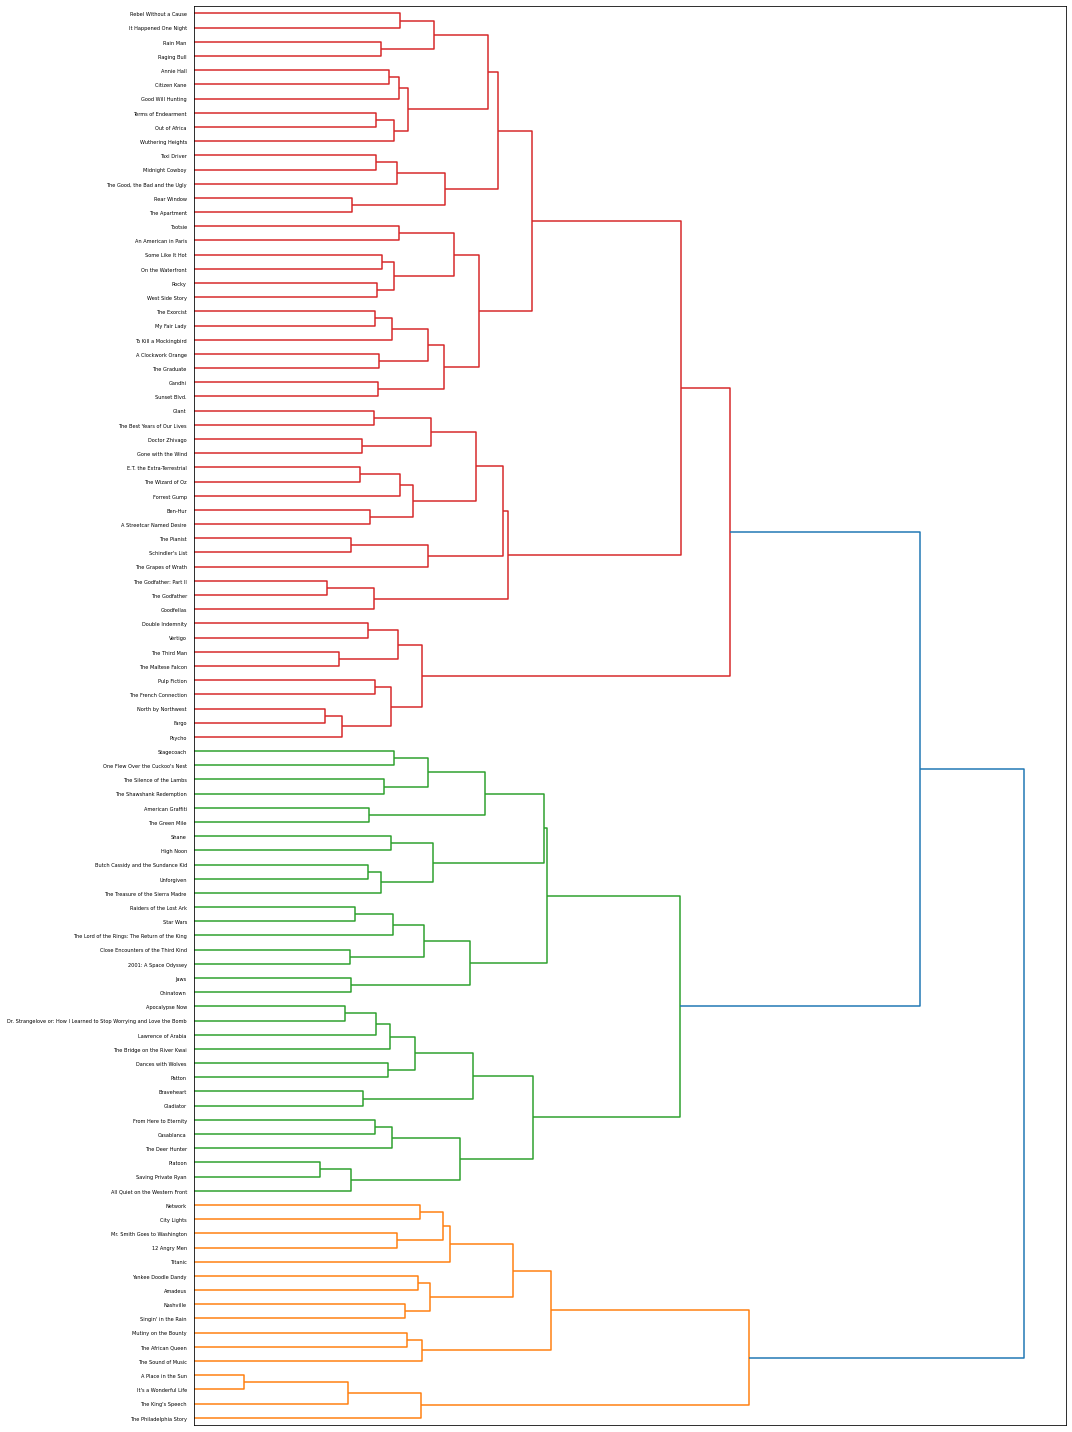

In [68]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout
plt.savefig(os.path.join(outputs,'ward_clusters.png'), dpi=200)

#### 3.1.9 - Latent Dirichlet Allocation

In [69]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [70]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [71]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 2.34 s, sys: 5.36 ms, total: 2.35 s
Wall time: 2.35 s
CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 276 ms


In [72]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1836


In [73]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [74]:
len(corpus)

100

In [75]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 22.9 s, sys: 0 ns, total: 22.9 s
Wall time: 22.9 s


In [76]:
print(lda[corpus[0]])

[(3, 0.118864946), (4, 0.8807635)]


In [77]:
topics = lda.print_topics(5, num_words=20)

In [78]:
lda.show_topics()

[(0,
  '0.005*"kill" + 0.005*"night" + 0.004*"arriv" + 0.004*"sing" + 0.004*"love" + 0.004*"friend" + 0.004*"home" + 0.004*"film" + 0.004*"prison" + 0.004*"go"'),
 (1,
  '0.004*"run" + 0.004*"first" + 0.004*"arriv" + 0.004*"kill" + 0.004*"friend" + 0.004*"home" + 0.004*"famili" + 0.004*"father" + 0.004*"polic" + 0.003*"away"'),
 (2,
  '0.006*"shark" + 0.005*"water" + 0.004*"boat" + 0.004*"discov" + 0.004*"escap" + 0.004*"ship" + 0.003*"home" + 0.003*"kill" + 0.003*"plan" + 0.003*"name"'),
 (3,
  '0.005*"love" + 0.004*"father" + 0.004*"home" + 0.004*"want" + 0.004*"marri" + 0.003*"famili" + 0.003*"night" + 0.003*"ask" + 0.003*"meet" + 0.003*"final"'),
 (4,
  '0.008*"kill" + 0.005*"ask" + 0.005*"meet" + 0.005*"car" + 0.005*"n\'t" + 0.005*"say" + 0.004*"go" + 0.004*"men" + 0.004*"two" + 0.004*"famili"')]

In [79]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [80]:
topics_matrix[0]

(0,
 [('kill', 0.0052970056),
  ('night', 0.0047856886),
  ('arriv', 0.0044878903),
  ('sing', 0.004409983),
  ('love', 0.004379427),
  ('friend', 0.0041808505),
  ('home', 0.004079715),
  ('film', 0.003986474),
  ('prison', 0.0038908517),
  ('go', 0.0038217062),
  ('two', 0.0037241052),
  ('shoot', 0.0036297035),
  ('say', 0.0035889305),
  ("n't", 0.0035420356),
  ('show', 0.0034370415),
  ('first', 0.0034121103),
  ('ask', 0.0033789123),
  ('day', 0.0031848776),
  ('call', 0.003166708),
  ('order', 0.0031576154)])

In [81]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

/home/rsouza/environments/default_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.002574  0.009961       1        1  35.030662
3     -0.027570  0.040293       2        1  20.915308
0     -0.051733  0.049709       3        1  16.281505
1     -0.033691 -0.101969       4        1  14.043184
2      0.110420  0.002006       5        1  13.729341, topic_info=       Term        Freq       Total Category  logprob  loglift
5516  shark  108.000000  108.000000  Default  30.0000  30.0000
1627   sing  104.000000  104.000000  Default  29.0000  29.0000
1394  water  140.000000  140.000000  Default  28.0000  28.0000
1670   boat  111.000000  111.000000  Default  27.0000  27.0000
395    love  281.000000  281.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
285      go   40.006375  403.020443   Topic5  -5.9942  -0.3243
49      ask   39.660805  441.325007   Topic5  -6.0029  -0.4238
585   sever   33.893362  186.456855   Topic5  -6.1600   0.2807
472    play   33.285633  178.621669   Topic5  -6.1781   0.3055
47    arriv   36.368564  377.242216   Topic5  -6.0895  -0.3535

[430 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
8017      4  0.940099    20th
7747      3  0.963067     9th
3509      3  0.963161   abbey
5706      2  0.960502  accent
18        2  0.755974  affair
...     ...       ...     ...
732       1  0.304018   young
732       2  0.359858   young
732       3  0.105476   young
732       4  0.105476   young
732       5  0.117884   young

[904 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

/home/rsouza/environments/default_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/rsouza/environments/default_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/rsouza/environments/default_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/rsouza/environments/default_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/rsouza/environments/defaul

#### 3.1.10 - [Enhancing TM Models](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/)